In [1]:
import math
import time
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

In [2]:
#ds = xr.open_mfdataset(['/glade/scratch/molina/spatial_storm_data_part1.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part2.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part3.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part4.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part5.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part6.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part7.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part8.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part9.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part10.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part11.nc',
#                        '/glade/scratch/molina/spatial_storm_data_part12.nc',
#                       ], 
#                       concat_dim="patch", combine='nested')

ds = xr.open_dataset('/glade/scratch/molina/spatial_storm_data_part1.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:  (patch: 90000, y: 32, x: 32)
Dimensions without coordinates: patch, y, x
Data variables: (12/24)
    tk_1km   (patch, y, x) float32 ...
    tk_3km   (patch, y, x) float32 ...
    tk_5km   (patch, y, x) float32 ...
    tk_7km   (patch, y, x) float32 ...
    ev_1km   (patch, y, x) float32 ...
    ev_3km   (patch, y, x) float32 ...
    ...       ...
    pr_5km   (patch, y, x) float32 ...
    pr_7km   (patch, y, x) float32 ...
    wmax     (patch, y, x) float32 ...
    dbz      (patch, y, x) float32 ...
    ctt      (patch, y, x) float32 ...
    uh25     (patch, y, x) float32 ...

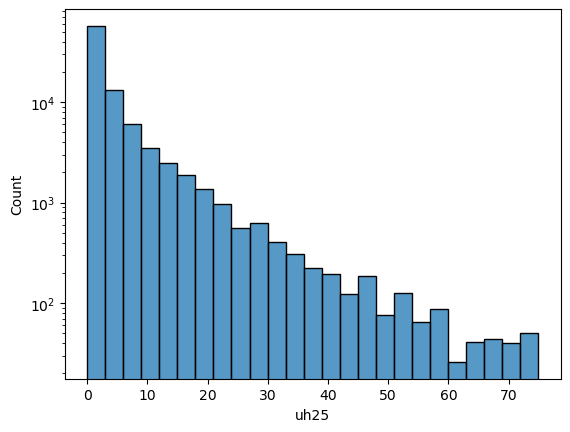

In [4]:
uh25mx = ds['uh25'].max(['y','x'],skipna=True)

sns.histplot(data = uh25mx.to_dataframe(), x = 'uh25', log_scale=(False,10), bins = 25)

In [5]:
# Bin uh25max into classes
n_class = 20
class_sep = 0.2

# This allows easy use of an arbitrary number of classes
# Can replace max(uh25mx) with another value for more consistent results
class_size = max(uh25mx.values) / n_class

print(class_size)
print(max(uh25mx.values))

uh_class = []
for val in uh25mx.values:
    
    # Actual class size = class_size * (1 - separation)
    val_class = math.floor(val / class_size)
    
    # Remove the bottom (separation*100)% of data within this class
    if val - (class_size * val_class) < class_size * class_sep:
        
        uh_class.append(-1)
        
    else:
        
        uh_class.append(val_class)

3.745030975341797
74.90062


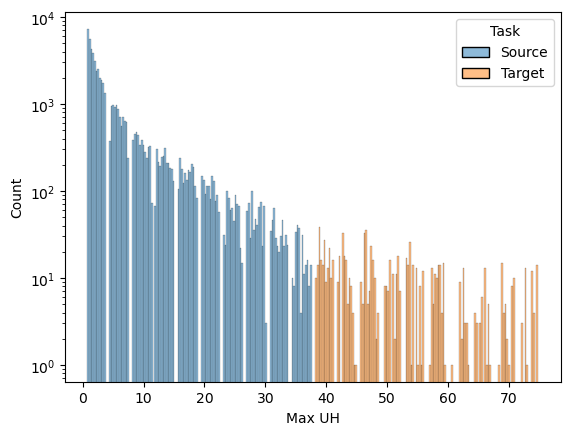

In [6]:
# Calculate number of (source) classes to populate w/ high domain gap and low domain gap
n_class = 20
domain_gap = 1.0
split = 0.5
high_cls = n_class * domain_gap * split # Note: these are floats
low_cls = n_class * (1-domain_gap) * split

# Populate high gap classes
source_cls = [x for x in range(math.floor(high_cls))]

# Populate low gap classes
for i in range(math.ceil(low_cls)):
    source_cls.append(math.floor((i * (n_class - high_cls) / low_cls) + high_cls))
    
target_cls = [x for x in range(n_class) if x not in source_cls]

source_or_target = []
drop = []

data_index = []
class_num = []
percent_clear = []

for num, i in enumerate(range(len(uh25mx))):
    
    if uh_class[i] in source_cls:
        
        source_or_target.append('Source')
        data_index.append(num)
        class_num.append(uh_class[i])
        tmp_perc = (xr.where(
            ds['dbz'].isel(patch=num) < 20, 1.0, 0.0).sum().values / (32 * 32)) * 100
        percent_clear.append(tmp_perc)
        
    elif uh_class[i] in target_cls:
        
        source_or_target.append('Target')
        data_index.append(num)
        class_num.append(uh_class[i])
        tmp_perc = (xr.where(
            ds['dbz'].isel(patch=num) < 20, 1.0, 0.0).sum().values / (32 * 32)) * 100
        percent_clear.append(tmp_perc)
        
    else:
        
        drop.append(i)

newuh25mx = [uh25mx.values[i] for i in range(len(uh25mx)) if i not in drop]

d = {'Max UH': newuh25mx, 'Task': source_or_target, 
     'DA Index': data_index, 'Class': class_num, 'Clear Percent': percent_clear}
df = pd.DataFrame(data=d)
sns.histplot(data=df, x='Max UH', hue = 'Task', log_scale=(False,True))

In [7]:
df

,Max UH,Task,DA Index,Class,Clear Percent
0,2.139619,Source,0,0,73.730469
1,1.608119,Source,1,0,50.976562
2,1.608119,Source,2,0,54.785156
3,1.729819,Source,4,0,39.746094
4,1.729819,Source,5,0,52.441406
...,...,...,...,...,...
56769,6.249523,Source,89993,1,62.695312
56770,1.137354,Source,89994,0,39.941406
56771,1.331187,Source,89995,0,37.402344
56772,16.999458,Source,89997,4,47.167969


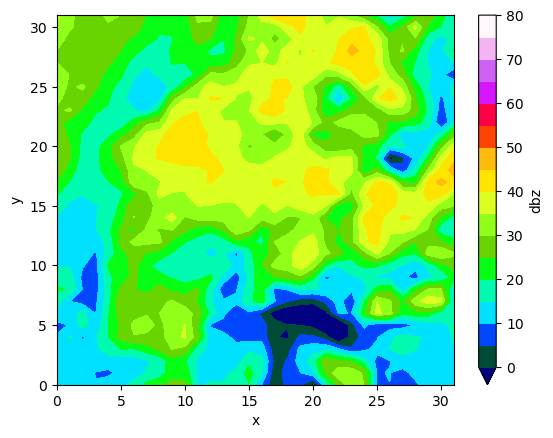

In [8]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds['dbz'].isel(patch=89995).plot.contourf(cmap="gist_ncar",levels=levels)

In [9]:
# exploring differences in percent clear by class -- nothing notable
#(
#    (
#        xr.where(
#            ds.isel(patch=df[df['Class']==0]['DA Index'].values)['dbz'] < 20,
#            1.0, 0.0).sum('y').sum('x') / (32 * 32)
#    ) * 100
#).mean('patch')

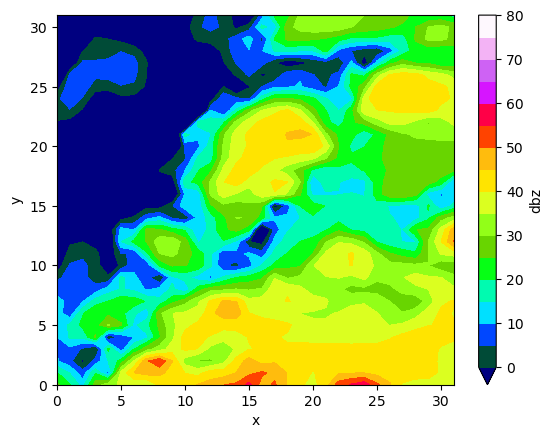

In [10]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Class']==4]['DA Index'].values)['dbz'].isel(
    patch=0).plot.contourf(cmap="gist_ncar",levels=levels)

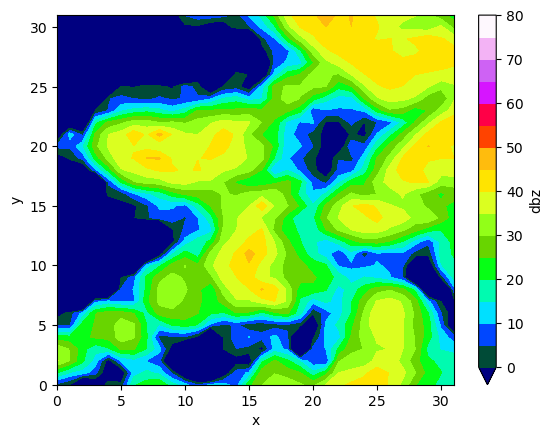

In [11]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Class']==9]['DA Index'].values)['dbz'].isel(
    patch=0).plot.contourf(cmap="gist_ncar",levels=levels)

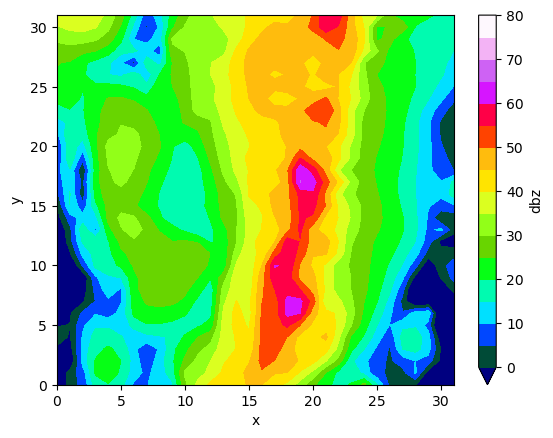

In [12]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Class']==14]['DA Index'].values)['dbz'].isel(
    patch=0).plot.contourf(cmap="gist_ncar",levels=levels)

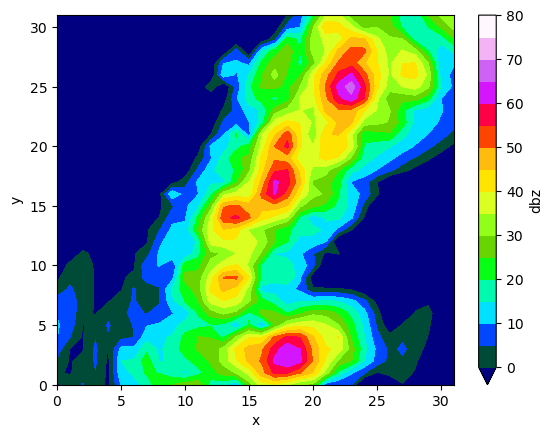

In [13]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Class']==19]['DA Index'].values)['dbz'].isel(
    patch=0).plot.contourf(cmap="gist_ncar",levels=levels)

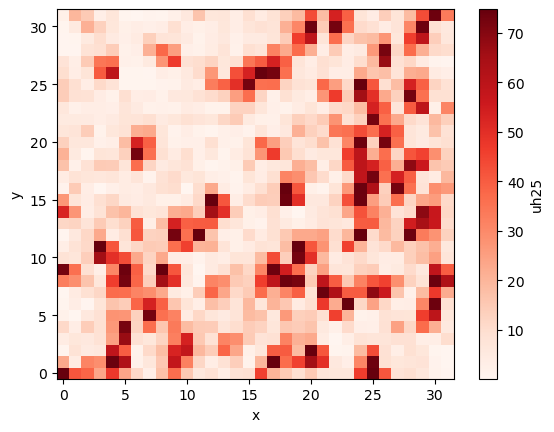

In [14]:
# visualizing uh max vals for class 19 (nothing interesting results)
ds.isel(patch=df[df['Class']==19]['DA Index'].values)['uh25'].max(
    'patch').plot(cmap="Reds")

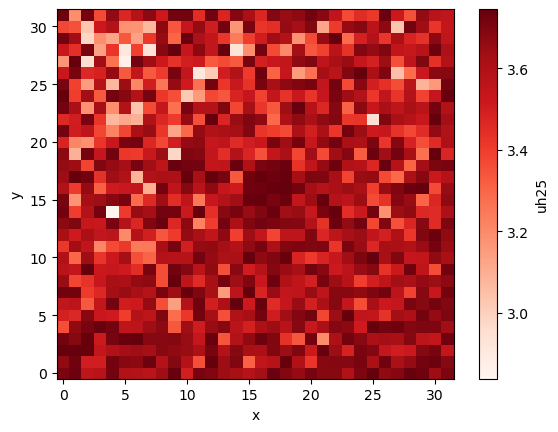

In [15]:
# visualizing uh max vals for class 0 (nothing interesting results)
ds.isel(patch=df[df['Class']==0]['DA Index'].values)['uh25'].max(
    'patch').plot(cmap="Reds")

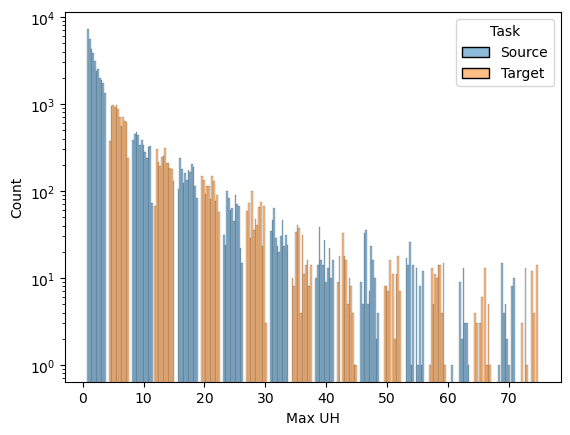

In [16]:
# Calculate number of (source) classes to populate w/ high domain gap and low domain gap
n_class = 20
domain_gap = 0.0
split = 0.5
high_cls = n_class * domain_gap * split # Note: these are floats
low_cls = n_class * (1-domain_gap) * split

# Populate high gap classes
source_cls = [x for x in range(math.floor(high_cls))]

# Populate low gap classes
for i in range(math.ceil(low_cls)):
    source_cls.append(math.floor((i * (n_class - high_cls) / low_cls) + high_cls))
    
target_cls = [x for x in range(n_class) if x not in source_cls]

source_or_target = []
drop = []

data_index = []
class_num = []
percent_clear = []

for num, i in enumerate(range(len(uh25mx))):
    
    if uh_class[i] in source_cls:
        
        source_or_target.append('Source')
        data_index.append(num)
        class_num.append(uh_class[i])
        tmp_perc = (xr.where(
            ds['dbz'].isel(patch=num) < 20, 1.0, 0.0).sum().values / (32 * 32)) * 100
        percent_clear.append(tmp_perc)
        
    elif uh_class[i] in target_cls:
        
        source_or_target.append('Target')
        data_index.append(num)
        class_num.append(uh_class[i])
        tmp_perc = (xr.where(
            ds['dbz'].isel(patch=num) < 20, 1.0, 0.0).sum().values / (32 * 32)) * 100
        percent_clear.append(tmp_perc)
        
    else:
        
        drop.append(i)

newuh25mx = [uh25mx.values[i] for i in range(len(uh25mx)) if i not in drop]

d = {'Max UH': newuh25mx, 'Task': source_or_target, 
     'DA Index': data_index, 'Class': class_num, 'Clear Percent': percent_clear}
df = pd.DataFrame(data=d)
sns.histplot(data=df, x='Max UH', hue = 'Task', log_scale=(False,True))

In [17]:
df

,Max UH,Task,DA Index,Class,Clear Percent
0,2.139619,Source,0,0,73.730469
1,1.608119,Source,1,0,50.976562
2,1.608119,Source,2,0,54.785156
3,1.729819,Source,4,0,39.746094
4,1.729819,Source,5,0,52.441406
...,...,...,...,...,...
56769,6.249523,Target,89993,1,62.695312
56770,1.137354,Source,89994,0,39.941406
56771,1.331187,Source,89995,0,37.402344
56772,16.999458,Source,89997,4,47.167969


In [18]:
# samples with more than 50% 'clear sky' conditions in patch, thus more likely discrete convection
df[df['Clear Percent'] >= 50.]

,Max UH,Task,DA Index,Class,Clear Percent
0,2.139619,Source,0,0,73.730469
1,1.608119,Source,1,0,50.976562
2,1.608119,Source,2,0,54.785156
4,1.729819,Source,5,0,52.441406
5,1.729819,Source,6,0,54.296875
...,...,...,...,...,...
56762,16.999458,Source,89985,4,52.343750
56763,1.416937,Source,89986,0,50.781250
56765,16.999458,Source,89988,4,53.222656
56768,16.999458,Source,89992,4,51.757812


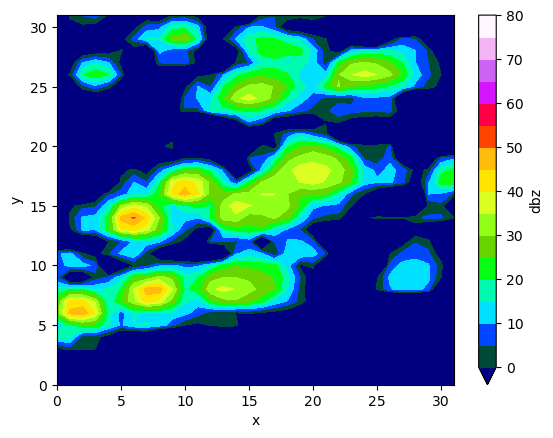

In [19]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[0]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)

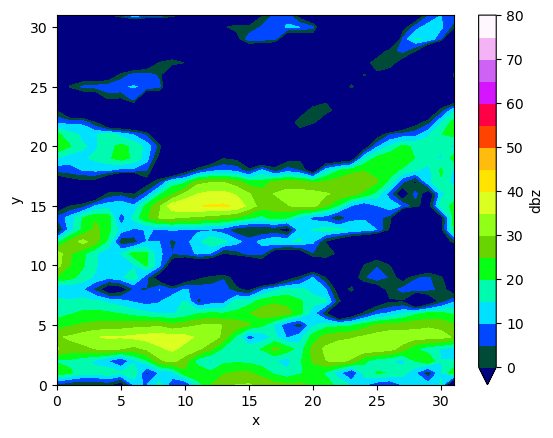

In [20]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[10]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)

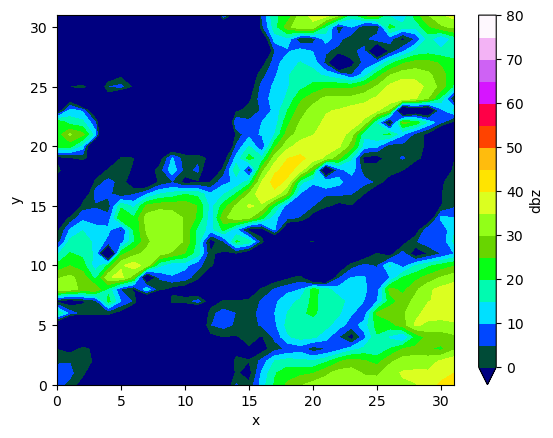

In [21]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[20]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)

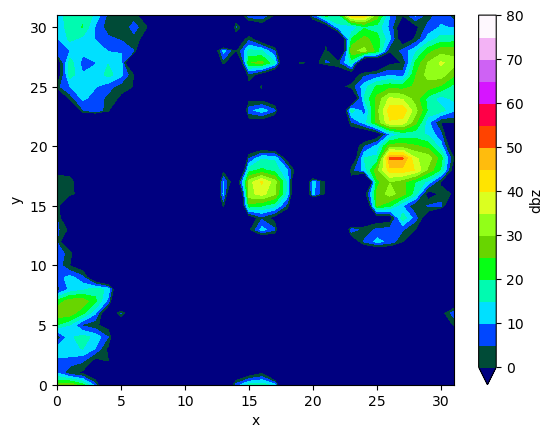

In [22]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[40]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)

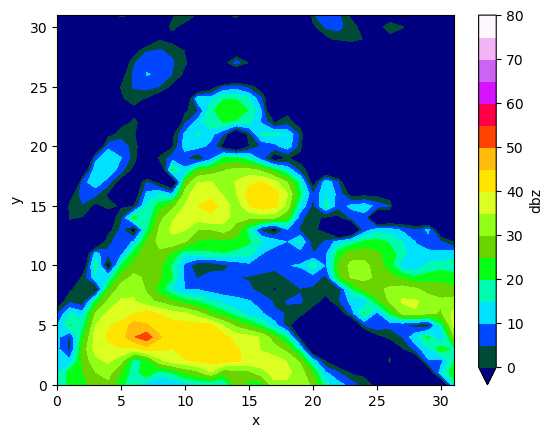

In [23]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[60]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)

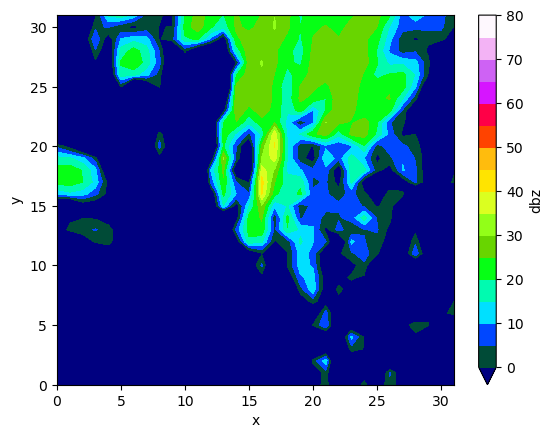

In [24]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[100]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)

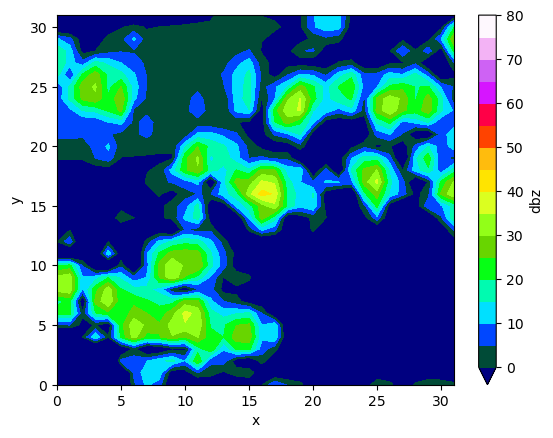

In [25]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[200]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)

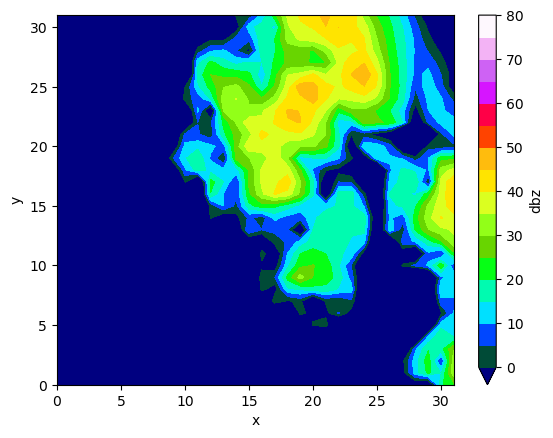

In [26]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[240]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)

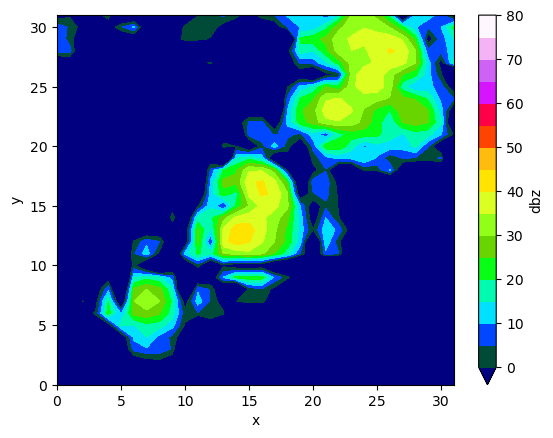

In [27]:
levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ds.isel(patch=df[df['Clear Percent'] >= 75.].iloc[320]['DA Index'])['dbz'].plot.contourf(cmap="gist_ncar",levels=levels)